# Imports

In [145]:
import pandas as pd
import spacy
from spacy.tokenizer import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Loading data from urls

- I'm going to combine two data sets together.
- I plan on the datasets having similar strains
- Hoping to merge together descriptions to create a more detailed description of each strain

In [6]:
url = "https://raw.githubusercontent.com/kushyapp/cannabis-dataset/master/Dataset/Strains/strains-kushy_api.2017-11-14.csv"
url2 = "https://raw.githubusercontent.com/MedicinalCabinet/DataScience/master/Data/cannabis.csv"
df = pd.read_csv(url)
df2 = pd.read_csv(url2)
ls = [df, df2]
for x in ls:
    x.info()
    print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9524 entries, 0 to 9523
Data columns (total 31 columns):
id             9524 non-null int64
status         9524 non-null int64
sort           9524 non-null int64
name           9523 non-null object
slug           0 non-null float64
image          0 non-null float64
description    1 non-null object
type           9500 non-null object
crosses        564 non-null object
breeder        8979 non-null object
effects        1015 non-null object
ailment        971 non-null object
flavor         971 non-null object
location       621 non-null object
terpenes       1 non-null object
thc            9524 non-null int64
thca           8635 non-null float64
thcv           8635 non-null float64
cbd            9524 non-null int64
cbda           8635 non-null float64
cbdv           8635 non-null float64
cbn            9524 non-null int64
cbg            8635 non-null float64
cbgm           8635 non-null float64
cbgv           8635 non-null float64
cbc   

# Helper Funtions

**get_lemmas** - return lemmas from a desired string

**get_word_vectors** - return word vectors from spacy

**pred** - make a prediction that return a nested dictionary of 5 closest neighbors and summary stats

**get_words** - create a word embedding visualization

**cleaner** - clean and merge the datasets

In [45]:
def get_lemmas(text):
    
    """Return the Lemmas"""
    
    lemmas = []
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

def get_word_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

def pred(x):
    """Make prediction and return nested dictionary
    
       x = string
    """
    # Load mode file and perform prediction
    model = pickle.load(open("mvp.sav", "rb"))
    x = [x]
    trans = tfidf.transform(x)
    pred = model.kneighbors(trans.todense())[1][0]
    
    #create empty dictionary
    pred_dict = {}
    
    #summary statistics of 5 closest neighbors
    for x in pred:
        print("\nStrain Name: ", df_test["Strain"][x])
        print("\nType: ", df_test["Type"][x])
        print("\nDescription: ", df_test["Description"][x])
        print("\nFlavor: ", df_test["Flavor"][x])
        print("\nEffects: ", df_test["Effects"][x])
        print("\nAilments: ", df_test["Ailment"][x])
        print("\n--------------------------------------------------------------------------------------------------------------------------------")
        
        # add new dictionary to pred_dict containing predictions
        preds_dict ={(1+len(pred_dict)): {"strain":df_test["Strain"][x],
                     "type": df_test["Type"][x],
                     "description": df_test["Description"][x],
                     "flavor": df_test["Flavor"][x],
                     "effects": df_test["Effects"][x],
                     "ailments": df_test["Ailment"][x]}}
        pred_dict.update(preds_dict)
    
    return pred, pred_dict

def get_words(x):
    
    """Get word vectors froma column of strings and plot"""
    
    #create a new column with lemmas
    df_test["lemmas"] = df_test[x].apply(get_lemmas)
    
    #create a list of lists from the lemmas column
    ls_lemmas = []
    for _ in df_test["lemmas"]:
        ls_lemmas.append(_)
    
    # create a list of items from the sublist items
    ls_lemmas_new = [item for sublist in ls_lemmas for item in sublist]
    
    # create list of lemmatized words
    lemmas = []
    for _ in ls_lemmas_new:
        _ = get_lemmas(_)
        lemmas.append(_)
    lemmas= [item for sublist in ls_lemmas for item in sublist]
    
    # create new list with lowered words
    lemmas_1 = []
    for _ in lemmas:
        _= _.lower()
        lemmas_1.append(_)
    
    # Get rid of duplicates
    lemmas = list(set(lemmas_1))
    
    # intialise pca model and tell it to project data down onto 2 dimensions
    pca = PCA(n_components=2)

    # fit the pca model to our spacy 300 dim data, this will work out which is the best 
    # way to project the data down that will best maintain the relative distances 
    # between data points. It will store these intructioons on how to transform the data.
    pca.fit(get_word_vectors(lemmas))

    # Tell our (fitted) pca model to transform our 300D data down onto 2D using the 
    # instructions it learnt during the fit phase.
    word_vecs_2d = pca.transform(get_word_vectors(lemmas))
    
    # create a nice big plot 
    plt.figure(figsize=(40,30))

    # plot the scatter plot of where the words will be
    sns.scatterplot(word_vecs_2d[:,0], word_vecs_2d[:,1], size=lemmas, )

    # for each word and coordinate pair: draw the text on the plot
    for word, coord in zip(lemmas, word_vecs_2d):
        x, y = coord
        plt.text(x, y, word, size= 30)

    # show the plot
    plt.show()
    
    return lemmas   

def cleaner(df1, df2):
    
    """Clean Dataframes and concat together & keep as much text information as possible"""
    
    print(f"Shape of df1: {df1.shape}")
    
    # Fill NaN with empyty strings to make concat easier
    df1 = df1.fillna("")
    
    # Concat all df1 text columns into a single column containing row corpus
    df1['alltext'] = df1['description'].str.cat(df1["type"], sep=" ")
    df1['alltext'] = df1['alltext'].str.cat(df1["effects"], sep=" ")
    df1['alltext'] = df1["alltext"].str.cat(df1["ailment"], sep=" ")
    df1['alltext'] = df1["alltext"].str.cat(df1["flavor"], sep=" ")
    df1['alltext'] = df1["alltext"].str.cat(df1["location"], sep=" ")
    df1['alltext'] = df1["alltext"].str.cat(df1["terpenes"], sep=" ")
    
    # Rename columns to match DF to concat too
    df1 = df1[["name","description", "alltext", "type", "effects", "ailment", "flavor"]]
    df1 = df1.rename(columns={"name":"Strain",
                              "type":"Type",
                              "effects":"Effects",
                              "flavor":"Flavor",
                              "description": "Description"
                                  })
    
    print(f"Shape of df2: {df2.shape}")
    
     # Fill NaN with empyty strings to make concat easier
    df2 = df2.fillna("")
    
    # Add 'ailment' column to df2 to make concat easier
    df2["ailment"] = ""
    
    # Concat all df2 text columns into a single column containing row corpus
    df2['alltext'] = df2['Effects'].str.cat(df2["Flavor"], sep=" ")
    df2['alltext'] = df2['alltext'].str.cat(df2["Description"], sep=" ")
    df2['alltext'] = df2["alltext"].str.cat(df2["Type"], sep=" ")

    # Concat df1 & df2
    df_cat = pd.concat([df1,df2], sort=False)
    
    print(f"Shape after concat: {df_cat.shape}")
    
    # Create column that shows the length of alltext to identify low word count rows
    df_cat["len_length"] = df_cat["alltext"].apply(lambda x: len(x))
    
    # Filter for rows only with more than 100 chars to filter our undescriptive rows out of the df
    condition = df_cat['len_length'] > 100
    df_cat = df_cat[condition]
    
    # Create "lemmas" column to clean and groupby on cleaned strain names
    df_cat['lemmas'] = df_cat['Strain'].apply(get_lemmas)
    
    # Combine lemmas lists to create cleaned strain names with hyphens removed and text lowered
    df_cat["strain_clean"] = df_cat["lemmas"].apply(lambda x: " ".join(x))
    df_cat["strain_clean"] = df_cat["strain_clean"].apply(lambda x: x.replace("-"," "))
    df_cat["strain_clean"] = df_cat["strain_clean"].apply(lambda x: x.lower())
    
    # Groupby "strain_clean" and agg using join then reset index
    df_cat = df_cat.groupby("strain_clean").agg(" ".join).reset_index()
    
    # Only keep needed columns
    keep_cols = ["strain_clean", "Type", "Effects", "ailment", "Flavor", "Description", "alltext"]
    df_cat = df_cat[keep_cols]
    
    # Rename columns to keep similar name structure
    df_cat = df_cat.rename(columns = {"strain_clean":"Strain",
                            "ailment":"Ailment"})
    
    # Add in single strain name
    df_cat["Strain"][0] = "one to one"
    
    # Title the strain names
    df_cat["Strain"] = df_cat["Strain"].apply(lambda x: x.title())
    
    # Remove duplicates and make text presentable
    ls_dupe = ["Effects", "Flavor", "Type", "Ailment", "alltext"]
    for x in ls_dupe:
        df_cat[x] = df_cat[x].apply(get_lemmas)
        df_cat[x] = df_cat[x].map(lambda x: list(set(map(str.lower, x))))
        df_cat[x] = df_cat[x].str.join(", ")
        df_cat[x] = df_cat[x].apply(lambda x: x.title())
    
    #Summary
    print(f"Final Shape: {df_cat.shape}")
    
    return df_cat

# Clean Data

In [36]:
# Create the nlp object
nlp = spacy.load("en_core_web_lg")

# Create tokenizer object
tokenizer = Tokenizer(nlp.vocab)

Shape of df1: (9524, 31)
Shape of df2: (2351, 6)
Shape after concat: (11875, 8)
Final Shape: (2362, 7)


,Strain,Type,Effects,Ailment,Flavor,Description,alltext
0,One To One,Hybrid,"Focused, Happy, Giggly, Euphoric, Relaxed, Hun...",,"Floral, Pungent, Earthy, Wood, Pepper, Diesel,...","Named for its equal balance of THC and CBD, On...","Creative, Nuanced, Appetite, Wood, Embrace, X,..."
1,100 Og,Hybrid,"Focused, Euphoric, Relaxed, Energetic, Creativ...",Depression,"Earthy, Sweet, Citrus",<p>This strain is named after it's high price ...,"High, Euphoric, Thank, Supposedly, Limonene, C..."
2,1024,"Sativa, Hybrid","Happy, Relaxed, Energetic, Creative, Anxious, ...","Inflammation, Depression, Stress, Pain","Spicy, Wood, Sage, Herbal, Pine",1024 is a sativa-dominant hybrid bred in Spai...,"Inflammation, Heritage, 1024, Breeder, Secret,..."


In [37]:
# Clean
df_test = cleaner(df, df2)
df_test.head(3)

Shape of df1: (9524, 31)
Shape of df2: (2351, 6)
Shape after concat: (11875, 8)
Final Shape: (2362, 7)


,Strain,Type,Effects,Ailment,Flavor,Description,alltext
0,One To One,Hybrid,"Focused, Happy, Giggly, Euphoric, Relaxed, Hun...",,"Floral, Pungent, Earthy, Wood, Pepper, Diesel,...","Named for its equal balance of THC and CBD, On...","Creative, Nuanced, Appetite, Wood, Embrace, X,..."
1,100 Og,Hybrid,"Focused, Euphoric, Relaxed, Energetic, Creativ...",Depression,"Earthy, Sweet, Citrus",<p>This strain is named after it's high price ...,"High, Euphoric, Thank, Supposedly, Limonene, C..."
2,1024,"Sativa, Hybrid","Happy, Relaxed, Energetic, Creative, Anxious, ...","Inflammation, Depression, Stress, Pain","Spicy, Wood, Sage, Herbal, Pine",1024 is a sativa-dominant hybrid bred in Spai...,"Inflammation, Heritage, 1024, Breeder, Secret,..."


# Model MVP: Nearest Neighbors

In [10]:
text = df_test["alltext"]

# Instantiate vectorizer object
tfidf = TfidfVectorizer(tokenizer=get_lemmas, min_df=0.025, max_df=.98, ngram_range=(1,3))

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(text) # Similiar to fit_predict

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
print(dtm.shape)
dtm.head()

(2362, 448)


,,,strain,strain aroma,uplifting,paranoid,1,10,70,8,...,white,white happy,widow,win,wood,x,yield,,energetic,
0,0.000000,0.056546,0.000000,0.0,0.0,0.0,0.0,0.0,0.156261,0.122695,...,0.0,0.0,0.0,0.0,0.103965,0.141891,0.0,0.077710,0.14334,0.0
1,0.108501,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0
2,0.090903,0.075786,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.139340,0.000000,0.0,0.000000,0.00000,0.0
3,0.000000,0.085825,0.158324,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.113288,0.00000,0.0


In [28]:
# Fit on TF-IDF Vectors
nn  = NearestNeighbors(n_neighbors=5, algorithm='kd_tree', radius=.5)
nn.fit(dtm)

review = [""" I cant sleep and have back spasms
"""]

new = tfidf.transform(review)
preds = nn.kneighbors(new.todense())
preds

(array([[1.18547038, 1.19982666, 1.2067418 , 1.20795828, 1.21305017]]),
 array([[1345, 1484, 1460,  421, 1383]]))

In [29]:
df_test["Description"][1345]

' Madagascar is an indica with a clean, floral smell. In true indica spirit, this strain produces a heavy-bodied, quick, and powerful sensation that is great for putting you to sleep in a hurry. Madagascar’s effects aren’t the longest-lasting but they hit quickly, making this strain great for those who just need a little help tackling insomnia.'

In [30]:
df_test.loc[1345]

Strain                                                Madagascar
Type                                                      Indica
Effects        Happy, Euphoric, Relaxed, Hungry, Mouth, Dry, ...
Ailment                    Stress, Pain, Muscle, Insomnia, Spasm
Flavor                                      Earthy, Skunk, Sweet
Description     Madagascar is an indica with a clean, floral ...
alltext        Bodied, Spirit, Euphoric, Need, Put, Tackle, F...
Name: 1345, dtype: object

# Save Model

In [31]:
filename = "mvp.sav"
pickle.dump(nn, open(filename, "wb"))

# Load Model

In [32]:
model = pickle.load(open("mvp.sav", "rb"))
review = ["pain"]
trans = tfidf.transform(review)
model.kneighbors(trans.todense())[1]

array([[1241,  898,  989, 1352,  954]])

# Results

In [33]:
df_test["Description"][1241]

''

In [49]:
df_test["Effects"][1241]

'Euphoric, Energetic, Creative, Uplifted, Talkative'

# Demo

In [69]:
preds2, pred_dict = pred("II have trouble sleeping and pain")
preds2


Strain Name:  Dorit

Type:  Indica

Description:  Dorit is a 70/30 indica-dominant strain tailored for patients treating pain, inflammation, indigestion, appetite loss, nausea, and sleep disorders. Bred in Israel by Tikun Olam, this strain inherits its name from Dorit Cohen, who helped found the company. 

Flavor:  Ammonia, Spicy, Minty, Herbal

Effects:  Euphoric, Relaxed, Uplifted, Tingly, Sleepy

Ailments:  

--------------------------------------------------------------------------------------------------------------------------------

Strain Name:  Jasmin

Type:  Hybrid

Description:  Jasmine, or Yasmin, is a 70/30 indica-dominant hybrid bred by the Israeli medical cannabis supplier Tikun Olam. Though originally developed to treat sleep disorders, patients also discovered its success in combating nausea, inflammation, pain, and indigestion.

Flavor:  Rose, Lavender, Sweet

Effects:  Happy, Euphoric, Relaxed, Hungry, Sleepy

Ailments:  

-------------------------------------------

array([ 701, 1138, 1533, 1769, 2305])

In [52]:
# return nested dictionary
pred_dict

{1: {'strain': 'Ultra Banana',
  'type': 'Indica',
  'description': 'Ultra Banana is a delicious, sleep-inducing cross of MK Ultra and Banana Kush. MK Ultra possesses strong indica-dominant genetics, including OG Kush and G13, which are amplified by the sweet and floral elements of Banana Kush. This sedating combination lays into the body, weighing the consumer down with potent relaxation ideal for late evenings. Enjoy Ultra Banana to help relieve restlessness, anxiety, and general pain while stimulating introspective thought. \xa0 \xa0',
  'flavor': 'Ammonia, Pineapple, Lemon',
  'effects': 'Giggly, Relaxed, Hungry, Tingly, Sleepy',
  'ailments': ''},
 2: {'strain': 'Madagascar',
  'type': 'Indica',
  'description': ' Madagascar is an indica with a clean, floral smell. In true indica spirit, this strain produces a heavy-bodied, quick, and powerful sensation that is great for putting you to sleep in a hurry. Madagascar’s effects aren’t the longest-lasting but they hit quickly, making t

# Model Stretch: 

- Create labels from type column
- apply xgboost and grid search to identify what type of cannabis a patient wants based on
their description
- Provide end user with a probability of type (indica, sativa, hybrid, indica-hybrid, sativa-hybrid) of cannabis they are looking for

In [91]:
df_test.head(1)

,Strain,Type,Effects,Ailment,Flavor,Description,alltext,lemmas
0,One To One,Hybrid,"Focused, Happy, Giggly, Euphoric, Relaxed, Hun...",,"Floral, Pungent, Earthy, Wood, Pepper, Diesel,...","Named for its equal balance of THC and CBD, On...","Creative, Nuanced, Appetite, Wood, Embrace, X,...",[ ]


In [55]:
df_test["Type"].value_counts()

Hybrid            1206
Indica             443
Sativa             273
Hybrid, Indica     269
Sativa, Hybrid     171
Name: Type, dtype: int64

In [93]:
# Create column of labels

# dictionary to map over Type column and create labels
label_dict = {"Hybrid": 5,
              "Indica": 4,
              "Sativa": 3,
              "Hybrid, Indica": 2,
              "Sativa, Hybrid": 1}

df_test['labels'] = df_test["Type"].map(label_dict)
df_test["labels"].value_counts()

5    1206
4     443
3     273
2     269
1     171
Name: labels, dtype: int64

In [94]:
train, test = train_test_split(df_test, random_state=42, stratify=df_test["labels"])
training, validation = train_test_split(train, random_state=42, stratify=train['labels'])

trainX = training.drop(columns=["labels", "lemmas"])
trainy = training.pop("labels")

valX = validation.drop(columns=["labels", "lemmas"])
valy = validation.pop("labels")

testX = test.drop(columns=["labels", "lemmas"])
testy = test.pop("labels")

trainX_cv = df_test.pop("alltext")
trainy_cv = df_test.pop("labels")

split_ls = [trainX, trainy, valX, valy, testX, testy, trainX_cv, trainy_cv]

for x in split_ls:
    print(f"Shape: {x.shape}")

Shape: (1328, 7)
Shape: (1328,)
Shape: (443, 7)
Shape: (443,)
Shape: (591, 7)
Shape: (591,)
Shape: (2362,)
Shape: (2362,)


In [126]:
svd = TruncatedSVD(n_components=300, 
                   algorithm='randomized',
                   n_iter=20)

vect = TfidfVectorizer(stop_words='english', 
                       ngram_range=(1,2))
clf = XGBClassifier()

lsi = Pipeline([('vect', vect), ('svd', svd)])
pipe = Pipeline([('lsi', lsi), ('clf', clf)])

parameters = {
    'lsi__svd__n_components': (10,55),
    'lsi__vect__max_df': (0.75, 1.0),
    'clf__max_depth': (5,10,15),
    'clf__n_estimators': (200, 500, 1000),
    'lsi__vect__min_df': (0.025, 0.05)
}

grid_search = GridSearchCV(pipe, parameters, cv=10, n_jobs=-1, verbose=10)
grid_search.fit(trainX_cv, trainy_cv)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('lsi',
                                        Pipeline(memory=None,
                                                 steps=[('vect',
                                                         TfidfVectorizer(analyzer='word',
                                                                         binary=False,
                                                                         decode_error='strict',
                                                                         dtype=<class 'numpy.float64'>,
                                                                         encoding='utf-8',
                                                                         input='content',
                                                                         lowercase=True,
                                                                         max_df=1.0,
            

In [127]:
grid_search.best_score_

0.8251555460201674

In [137]:
# Predictions on a test
pred = grid_search.predict(["I have trouble sleeping at night"])
pred

array([4])

In [143]:
# Probabilities to return
grid_search.predict_proba(["I have trouble sleeping"])

array([[0.01418492, 0.05303662, 0.03540078, 0.71944135, 0.1779363 ]],
      dtype=float32)

In [140]:
# Save
filename = "stretch.sav"
pickle.dump(grid_search, open(filename, "wb"))

In [141]:
# Load
model = pickle.load(open("stretch.sav", "rb"))
review = ["pain"]
model.predict(review)

array([4])

In [144]:
model.predict_proba(["I have trouble sleeping at night"])

array([[0.01418492, 0.05303662, 0.03540078, 0.71944135, 0.1779363 ]],
      dtype=float32)

# Data Viz

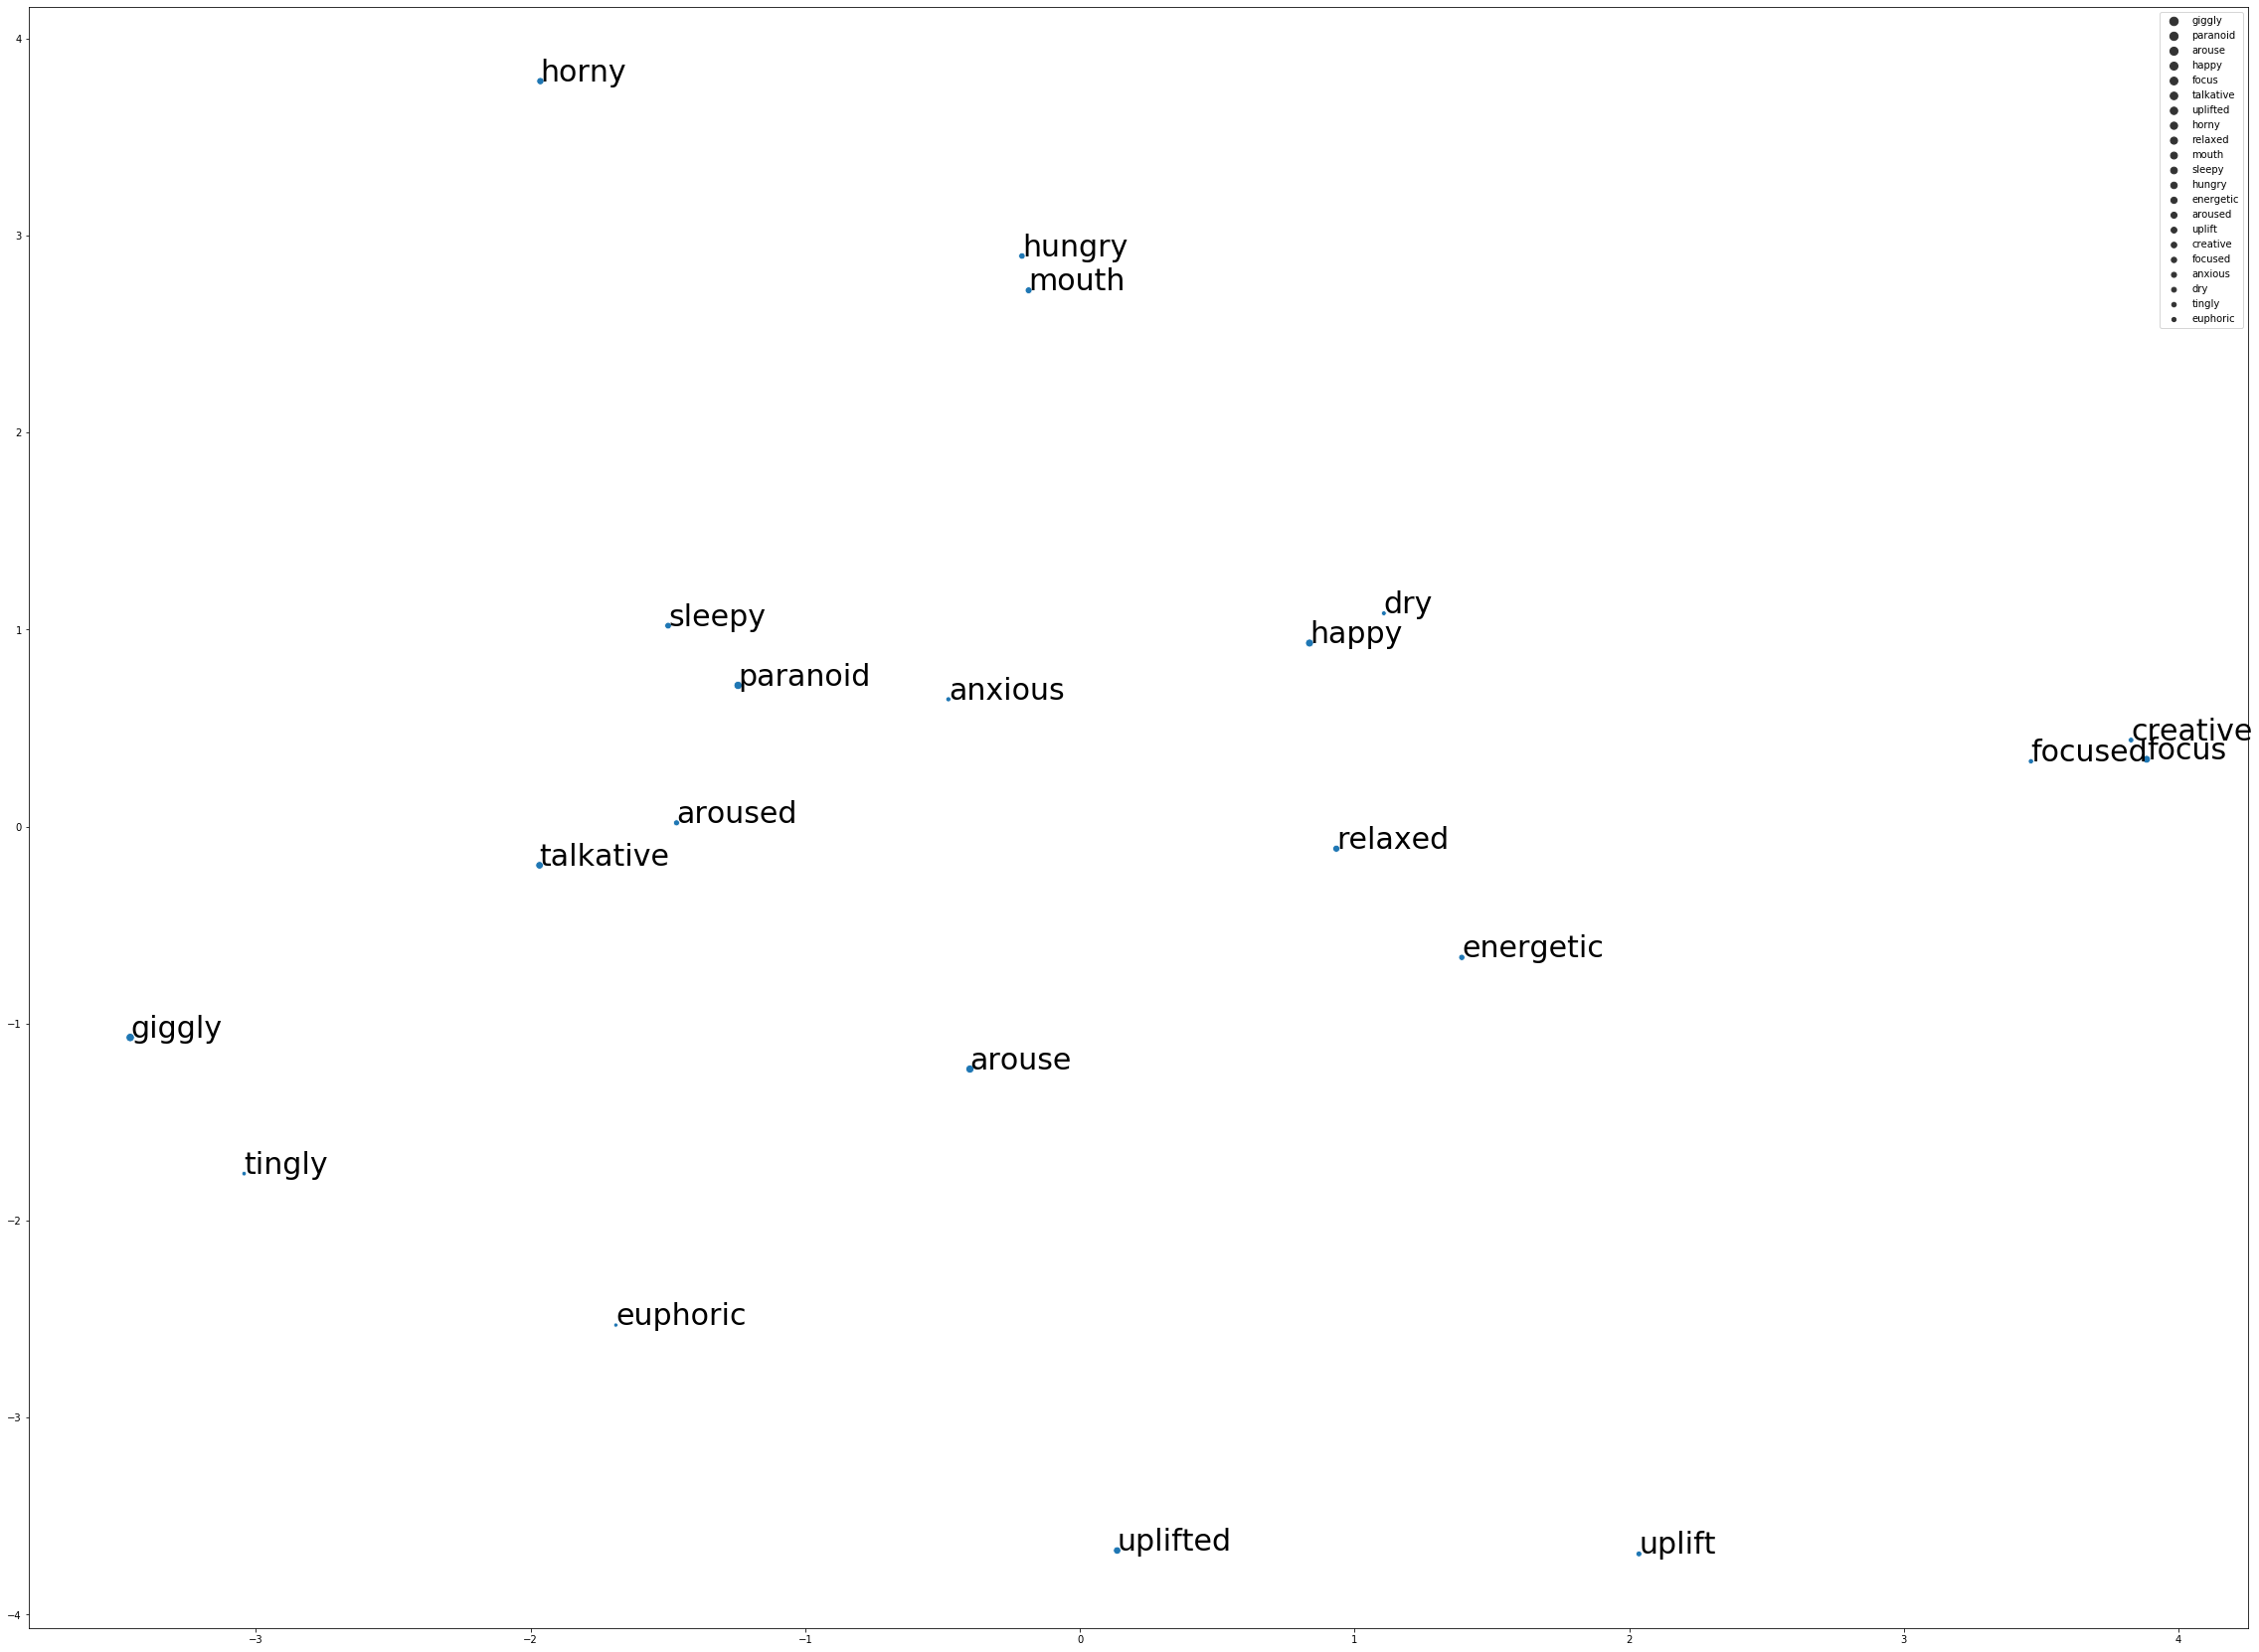

['giggly',
 'paranoid',
 'arouse',
 'happy',
 'focus',
 'talkative',
 'uplifted',
 'horny',
 'relaxed',
 'mouth',
 'sleepy',
 'hungry',
 'energetic',
 'aroused',
 'uplift',
 'creative',
 'focused',
 'anxious',
 'dry',
 'tingly',
 'euphoric']

In [484]:
# Word embeddings for cannabis effects
get_words("Effects")

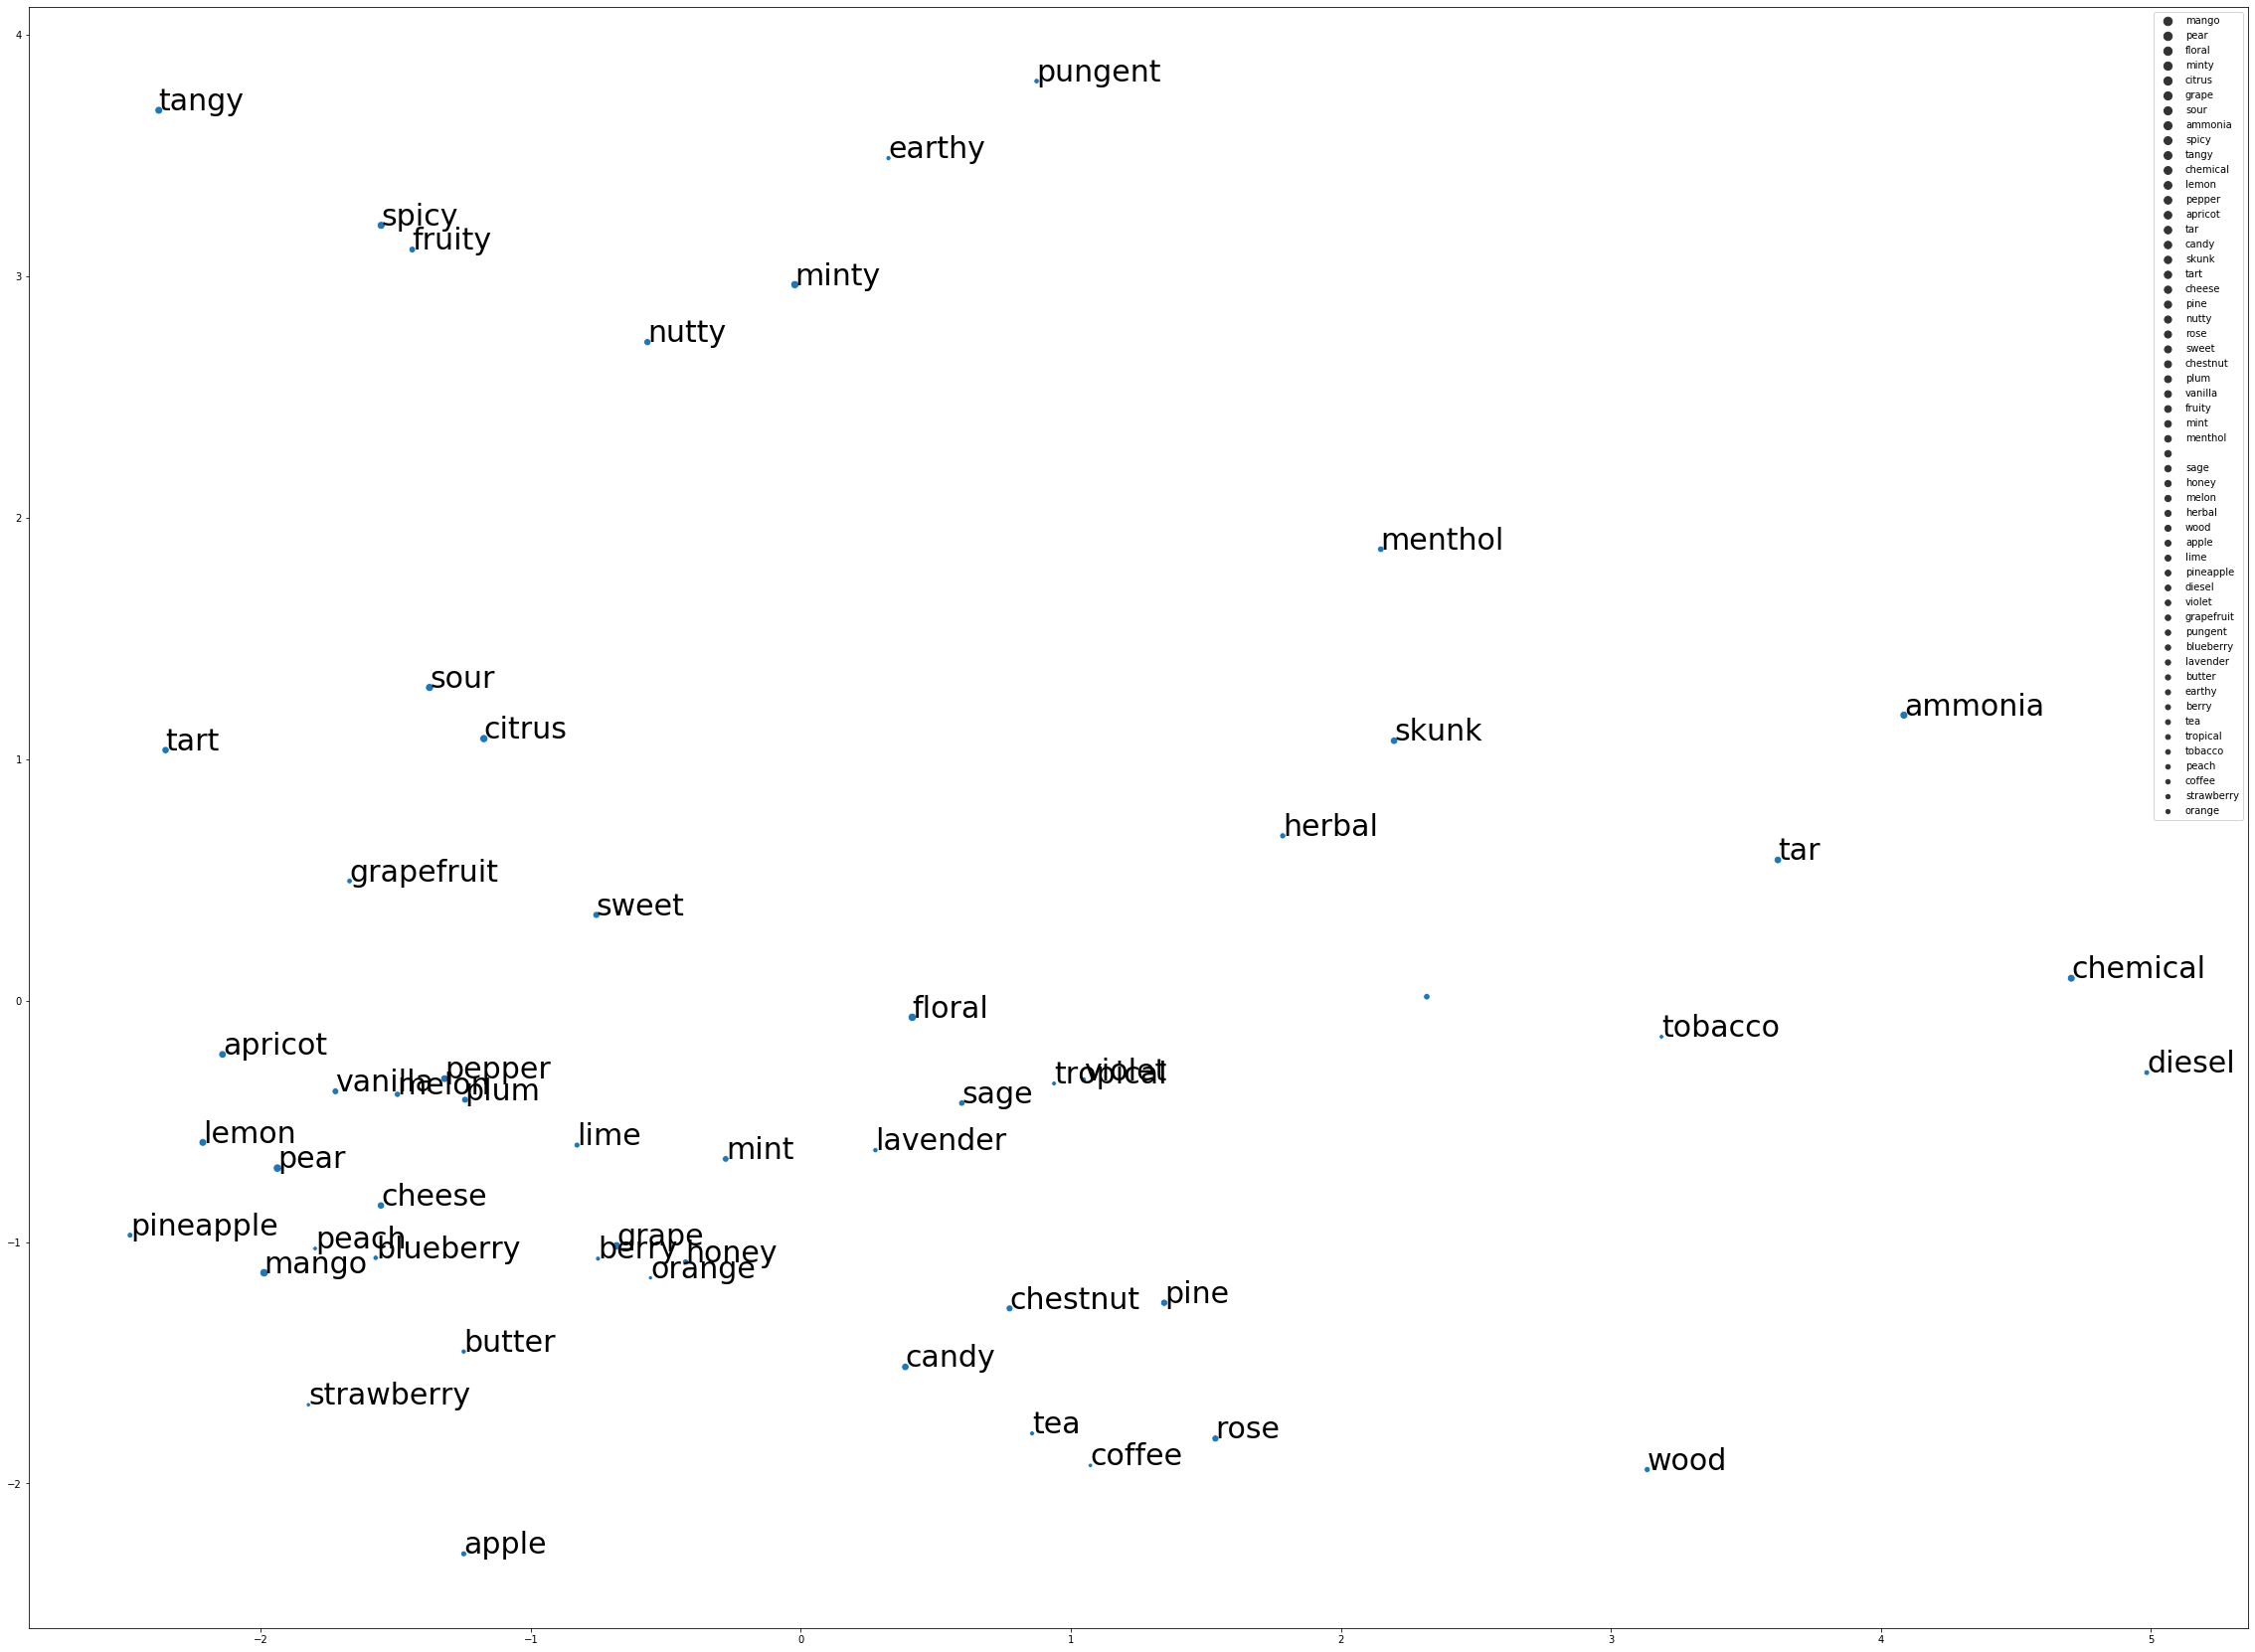

['mango',
 'pear',
 'floral',
 'minty',
 'citrus',
 'grape',
 'sour',
 'ammonia',
 'spicy',
 'tangy',
 'chemical',
 'lemon',
 'pepper',
 'apricot',
 'tar',
 'candy',
 'skunk',
 'tart',
 'cheese',
 'pine',
 'nutty',
 'rose',
 'sweet',
 'chestnut',
 'plum',
 'vanilla',
 'fruity',
 'mint',
 'menthol',
 ' ',
 'sage',
 'honey',
 'melon',
 'herbal',
 'wood',
 'apple',
 'lime',
 'pineapple',
 'diesel',
 'violet',
 'grapefruit',
 'pungent',
 'blueberry',
 'lavender',
 'butter',
 'earthy',
 'berry',
 'tea',
 'tropical',
 'tobacco',
 'peach',
 'coffee',
 'strawberry',
 'orange']

In [485]:
# Word embeddings for cannabis flavor
get_words("Flavor")

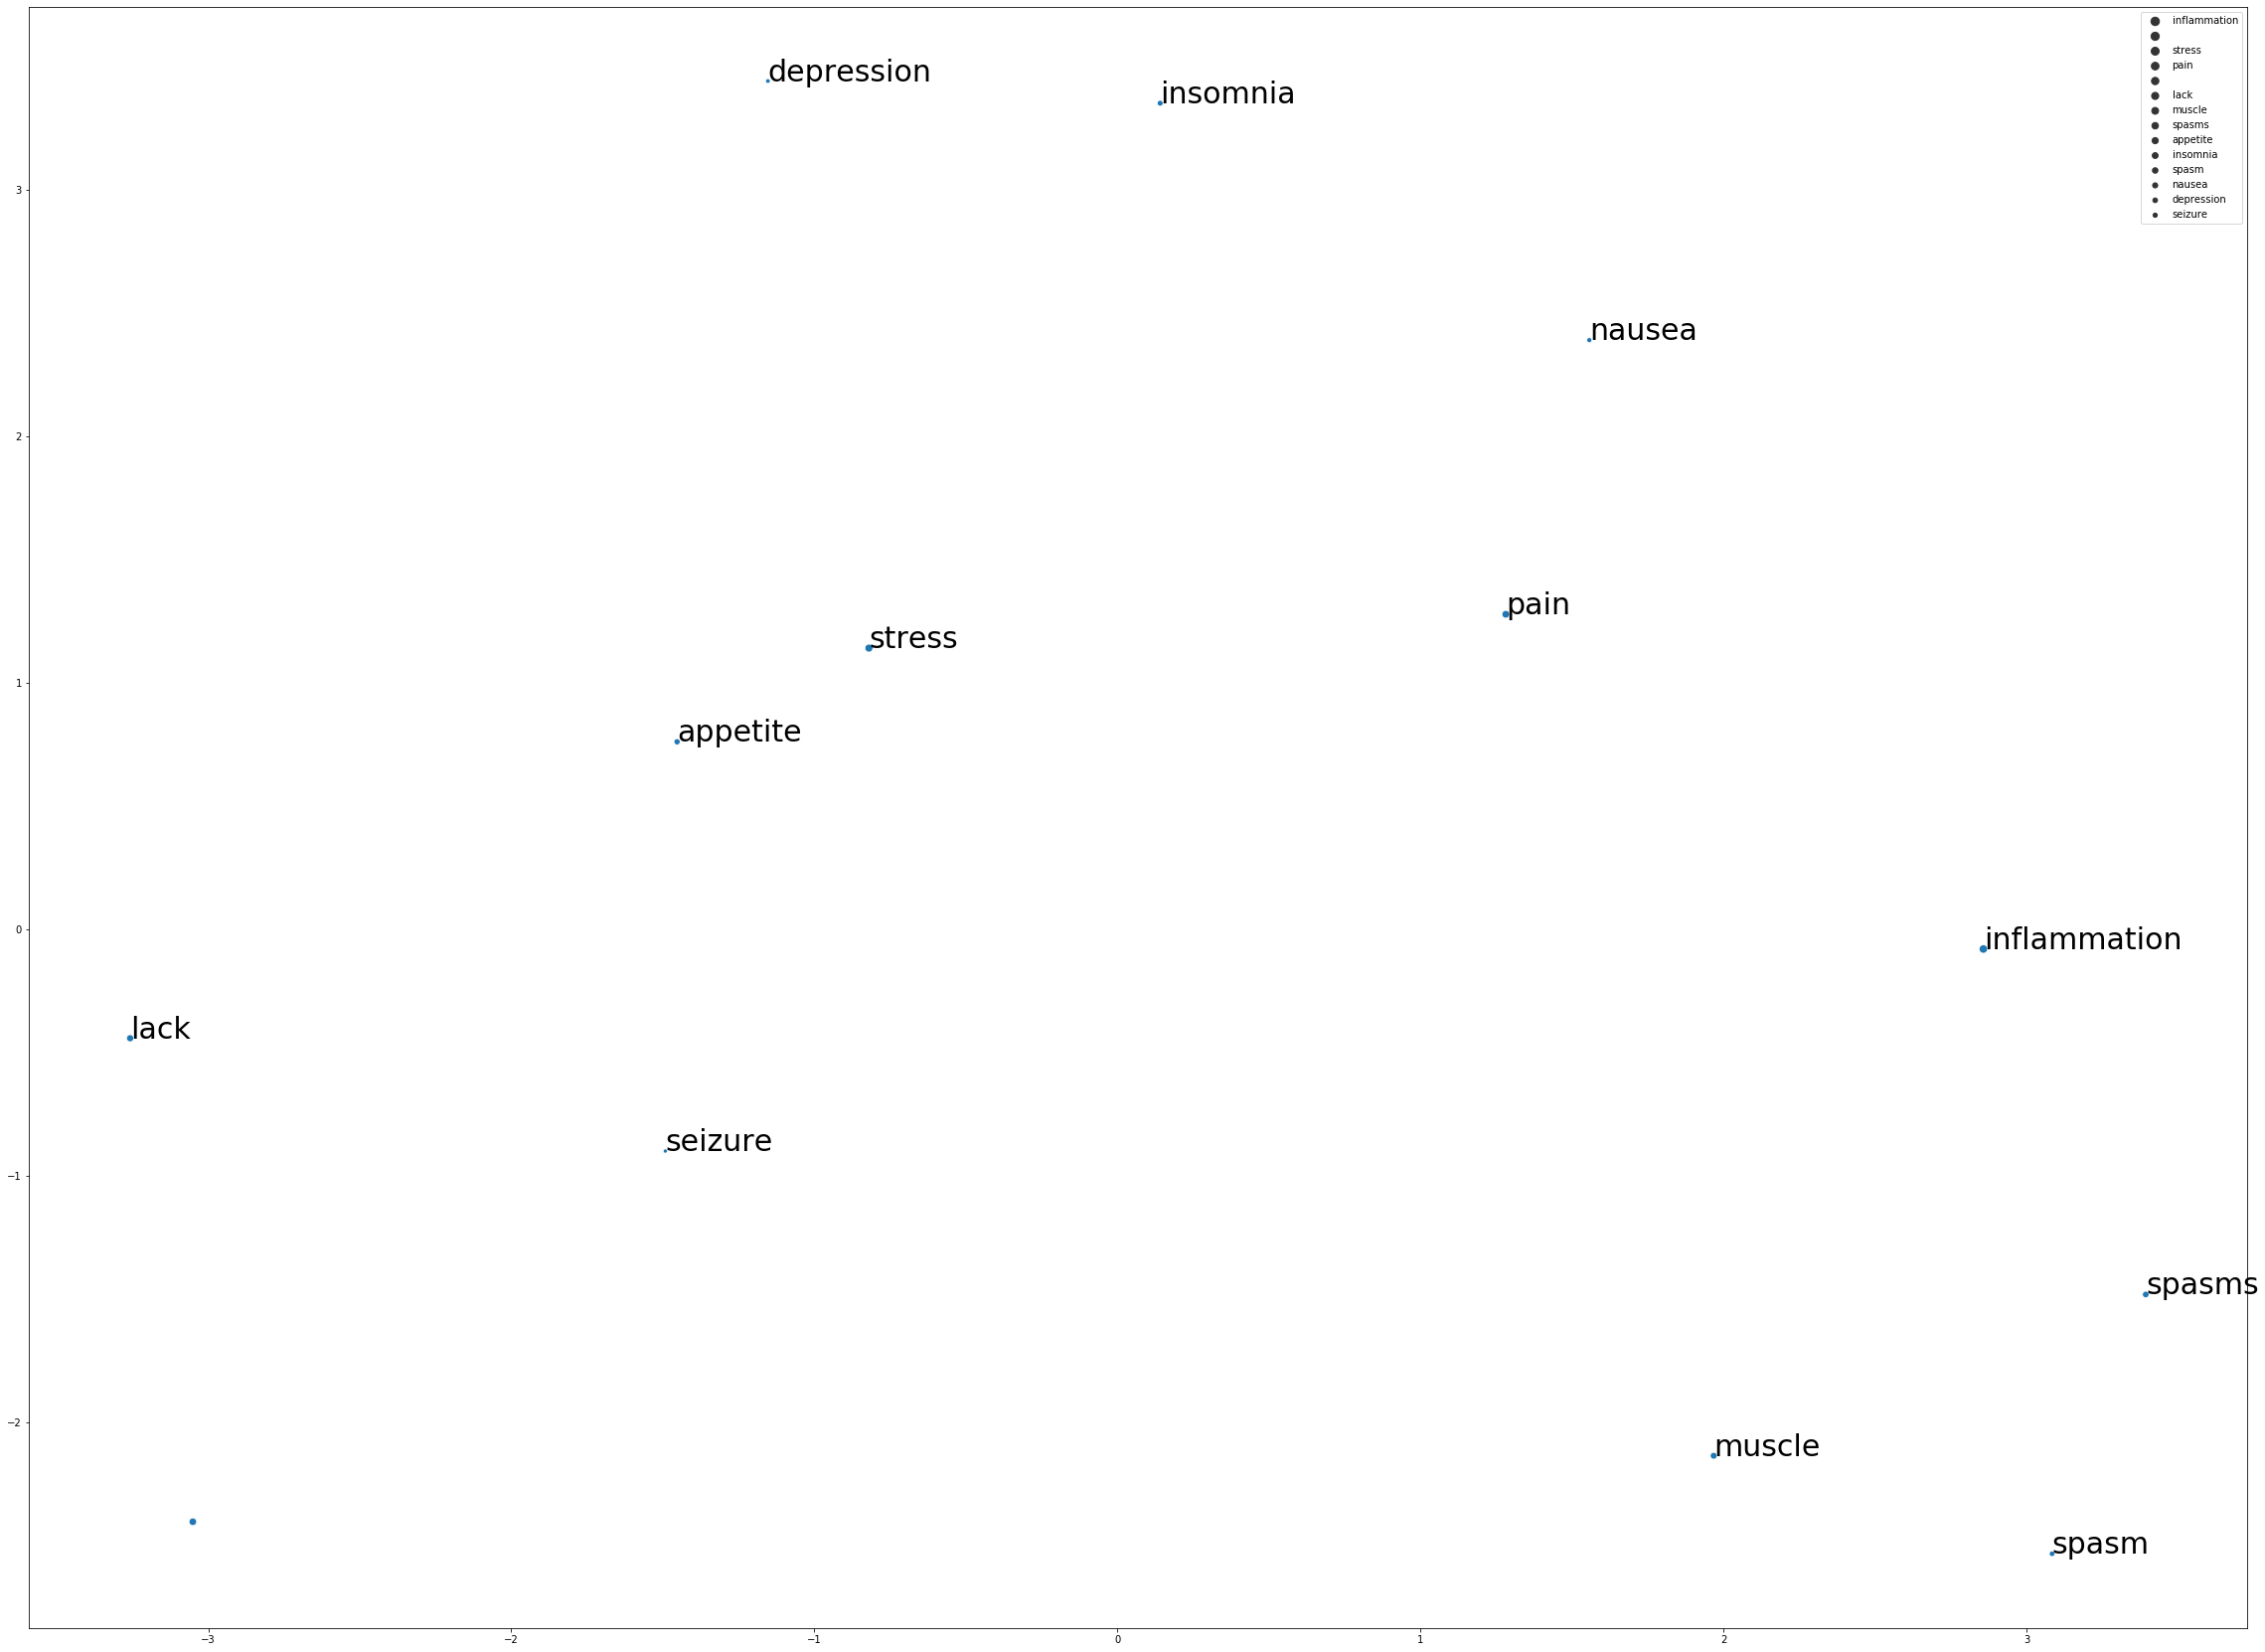

['inflammation',
 '  ',
 'stress',
 'pain',
 ' ',
 'lack',
 'muscle',
 'spasms',
 'appetite',
 'insomnia',
 'spasm',
 'nausea',
 'depression',
 'seizure']

In [53]:
get_words("Ailment")